# Important Implementation Note
We've defined 2 separate GAN's below: a basic GAN and a DCGAN. The following code should be compatible with both networks. If you wish to switch between the different implementations, you have to comment some codes.

**COMPLETE ANYWHERE WITH ### and ...**

# Defining The Accelerator
Using a GPU if available, else a CPU. In this case, satisfactory performance is obtained with a CPU and training time is not too high.

In [13]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


#Importing libraries

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset


In [16]:
#Loading the training data
###CHANGE THE DATA PATH ACCORDING TO YOUR FILES
train = pd.read_csv('/content/drive/MyDrive/mnist_train.csv')

# Defining the Training Data
From the original MNIST dataset, 60000 images are chosen for training. The training data is reshaped into 28x28 numpy array to represent the grayscale images. Finally, an important step of normalization follows to allow the GAN to converge better.

In [17]:
train_data = train.drop(labels = ['label'], axis = 1)
train_data = train_data.values.reshape(-1, 28, 28)
train_data = train_data/255.0

#To create some space
del train

# Visualizing the Data
Randomly plotting one of the training examples to catch a drift about the training data.

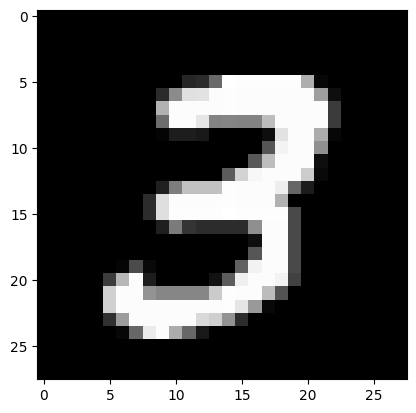

In [18]:
plt.imshow(train_data[7], cmap = 'gray')

# Using DataLoader
To allow for efficient iteration over the different mini-batches using a hard coded batch size of 32.

In [19]:
###COMPLETE HERE

#Converting to torch tensor
train_data = torch.from_numpy(train_data)

#Checking to confirm dtype as tensor
print(isinstance(train_data, torch.Tensor))

#DATALOADER
random_seed = 1
batch_size = 32
train_dl = DataLoader(train_data, batch_size, shuffle=True)

True


# Noise Generation
The input to the generator in a GAN is usually random noise. Here, I use torch.rand to generate random numbers between 0 and 1 and then rescale the numbers to fall between -1 and 1 so as to make the mean 0 for the uniform distribution to facilitate the training of the GAN.

In [20]:
def random_noise_generator(batch_size, dim):
    return torch.rand(batch_size, dim)*2 - 1

# Discriminator Model for Basic GAN
The discriminator model is fairly straightforward having a few fully connected layers having one small caveat, instead of the usual ReLU for activation, here, we used a **leaky ReLU**. This is because, a leaky ReLU has a small gradient for negative values of input, allowing for a stronger flow of gradients from the discriminator to the generator. Also, some dropout layers have been added in intermediate stages to prevent overfitting.
Further, the final output is supposed to be between 0 and 1 (to predict if real or fake), however, the loss function used later on is **BCEWithLogitsLoss** (for numerical stability) which combines the sigmoid with the normal binary cross entropy function, so, no activation function is applied to the output.

In [21]:
#COMPLETE HERE
#linear layers with hidden size 4 and then 2
class Discriminator1(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size,hidden_size*4 )
        self.fc2 = nn.Linear(hidden_size*4,hidden_size*2 )
        self.fc3 = nn.Linear(hidden_size*2,hidden_size )
        self.fc4 = nn.Linear(hidden_size,output_size )

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        #float in Relu is 0.2
        x = x.view(-1, 28*28)

        # layer 1
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)

        # layer 2
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)

        # layer 3
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)

        # layer 4
        out = self.fc4(x)

        return out


# Discriminator Model for DCGAN
The discriminator model for a DCGAN can be implemented in many different ways, but it's recommended by the authors of the original paper on DCGAN's to have **strided convolutions** for downscaling, remove any fully connected layers, use batch normalization and the **leaky ReLU** for activation of all layers except sigmoid for the last one. We add a few dropout layers additionally to prevent overfitting.




In [22]:
#Comment this if you want to run the Basic GAN instead of the DCGAN
###COMPLETE HERE
class Discriminator2(nn.Module):

    def __init__(self):
        super().__init__()

        # conv layers
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)

        # Dropout layers
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3_drop = nn.Dropout2d(0.25)

        self.fc = nn.Linear(12544, 1)


    def forward(self, x):
        x = x.view(-1, 1, 28, 28)

        # layer 1
        x = self.conv0(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv0_drop(x)

        # layer 2
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv1_drop(x)

        # layer 3
        x = self.conv2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv2_drop(x)

        # layer 4
        x = self.conv3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv3_drop(x)

        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

# Generator Model for Basic GAN
The generator model is quite similar to the discriminator, with two small differences:
1. Instead of the input being downscaled, it's upscaled to reach expected dimensions of MNIST dataset images.
2. Final activation function **tanh** is applied to the output bringing its values between -1 and 1 for best performance.

In [23]:
###COMPLETE HERE
class Generator1(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2, hidden_size*4)
        self.fc4 = nn.Linear(hidden_size*4, output_size)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):

        # layer 1
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)

        # layer 2
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)

        # layer 3
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)

        # layer 4
        x = self.fc4(x)
        out = torch.tanh(x)

        return out


# Generator Model for DCGAN
Similar to the discrminator, there are many possible implementations but the authors of the original paper on DCGAN's recommend using **transposed convolutions** for upscaling, using batch normalization in intermediate stages and having a **ReLU** activation function after all layers except a tanh activation for the output.

In [24]:
#Comment this if you want to run the Basic GAN instead of the DCGAN
#COMPLETE HERE
class Generator2(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)

    def forward(self, x):
        # layer 0
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)

        # layer 1
        x = self.trans_conv1(x)
        x = F.relu(x)
        x = self.bn1(x)

        # layer 2
        x = self.trans_conv2(x)
        x = F.relu(x)
        x = self.bn2(x)

        # layer 3
        x = self.trans_conv3(x)
        x = F.relu(x)

        # layer 4
        x = self.trans_conv4(x)
        x = torch.tanh(x)

        return x

# Setting Model Hyperparameters for Basic GAN
Input size to the generator is hard coded to be 100. Can be manipulated to check variations in performance.

# Discriminator Loss
Discriminator loss is the resultant sum of two components:
1. On passing real training set images through the discriminator, the output values are compared with 1 (for real images) and real loss is calculated.
2. On passing random noise through the generator, fake images are created which are further passed through the discriminator. These outputs are compared with 0 (for fake images) and fake loss is calculated.

We have defined relevant functions to calculate real loss, fake loss and the resultant sum of these two losses.

In [25]:
###COMPLETE HERE
Loss = nn.BCEWithLogitsLoss()
def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = Loss(real_out.squeeze(), real_label.squeeze())
    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = Loss(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss

# Generator Loss
Passing random noise through the generator, we get fake images. On further passing these through the discriminator, we get their output labels. Since we want the generator to fool the discriminator, these output labels are compared with 1 (for supposedly real images) and loss is calculated.

In [26]:
###COMPLETE HERE
def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = Loss(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

# Defining Optimizers
If going with the basic GAN:
Using Adam optimizers for both discriminator and generator. The learning rate is adjusted to 0.002, a slight deviation from the original paper, to allow for faster learning in this case.

If using the DCGAN architecture:
Using Adam optimizers for the generator and discriminator with a slight deviation from the usual settings, setting the learning rate to 0.0002 and $\beta_{1}$ to be 0.5 according to the authors of the DCGAN paper for best performance.

In [27]:
###COMPLETE HERE
#Creating instances of models


def create_model(method=1):
    # if method == 1 gan model is basic
    # else gan model is basic DCGAN
    if method==1:

        #For Discriminator
        input_disc = 784
        hidden_disc = 32
        output_disc = 1

        #For Generator
        input_gen = 100
        hidden_gen = 32
        output_gen = 784
        D = Discriminator1(input_disc,hidden_disc,output_disc)
        G = Generator1(input_gen,hidden_gen,output_gen)
        lr = 0.001
        betas = (0.9, 0.999)
    else:
        D = Discriminator2()
        G = Generator2()
        lr = 0.0002
        betas = (0.5, 0.999)

    #Sanity check of the model instances
    print(D)
    print(G)

    #Passing to the GPU
    D = D.to(device)
    G = G.to(device)

    D = D.float()
    G = G.float()


    disc_opt = optim.Adam(D.parameters(), lr = lr, betas = betas)
    gen_opt = optim.Adam(G.parameters(), lr = lr, betas = betas)

    return (D,G), (disc_opt,gen_opt)

gan1, opt1 = create_model(method=1)
gan2, opt2 = create_model(method=2)


Discriminator1(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator1(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Discriminator2(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv0_drop): Dropout2d(p=0.25, inplace=False)
  (conv1_drop): Dropo

# Training the GAN
The GAN was trained with a mini-batch size of 32 for 25 epochs and samples of the generator output were printed every 5 epochs to monitor the progress of the generator.

In [28]:
###COMPLETE HERE
def train(D, G, disc_opt, gen_opt, train_dl, batch_size = 32, epochs = 25, gen_input_size = 100):

    disc_losses = []
    gen_losses = []

    #Having a fixed sample to monitor the progress of the generator
    sample_size = 16
    fixed_samples = random_noise_generator(sample_size, gen_input_size)
    fixed_samples = fixed_samples.to(device)

    #Going into training mode
    D.train()
    G.train()

    for epoch in range(epochs + 1):

        disc_loss_total = 0
        gen_loss_total = 0
        gen_out = 0

        for train_x in train_dl:
            #Discriminator training
            disc_opt.zero_grad()

            train_x = train_x*2 - 1          #Converting the real images to have values between -1 and 1
            train_x = train_x.to(device)     #Passing to GPU
            real_out = D(train_x.float())

            disc_gen_in = random_noise_generator(batch_size, gen_input_size)
            disc_gen_in = disc_gen_in.to(device)   #Passing to GPU

            disc_gen_out = G(disc_gen_in.float()).detach()  #Detaching to avoid training the generator
            fake_out = D(disc_gen_out.float())

            disc_loss = discriminator_loss(real_out, fake_out)  #Loss calculation
            disc_loss_total += disc_loss
            disc_loss.backward()
            disc_opt.step()

            #Generator training
            gen_opt.zero_grad()


            gen_out = G(disc_gen_in.float())     #Feeding noise into the generator
            gen_disc_out = D(gen_out.float())      #Passing into the discrminator

            gen_loss = generator_loss(gen_disc_out)   #Generator loss calculation
            gen_loss_total += gen_loss
            gen_loss.backward()
            gen_opt.step()

        disc_losses.append(disc_loss_total.to("cpu"))
        gen_losses.append(gen_loss_total.to("cpu"))


        #Plotting samples every 5 epochs
        if epoch%5 == 0:
            G.eval()                   #Going into eval mode to get sample images
            samples = G(fixed_samples.float())
            G.train()                   #Going back into train mode

            fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
            for ax, img in zip(axes.flatten(), samples):
               img = img.cpu().detach()
               ax.xaxis.set_visible(False)
               ax.yaxis.set_visible(False)
               im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')


        #Printing losses every epoch
        print("Epoch ", epoch, ": Discriminator Loss = ", disc_loss_total/len(train_dl), ", Generator Loss = ", gen_loss_total/len(train_dl))

    return disc_losses, gen_losses


def fit(gan, opt,train_dl, batch_size ):
    disc_losses, gen_losses = train(gan[0], gan[1], opt[0], opt[1], train_dl, batch_size)
    return disc_losses, gen_losses

Epoch  0 : Discriminator Loss =  tensor(0.8393, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.9620, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  1 : Discriminator Loss =  tensor(0.8568, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.6511, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  2 : Discriminator Loss =  tensor(1.1123, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.1412, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  3 : Discriminator Loss =  tensor(1.1481, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.0801, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  4 : Discriminator Loss =  tensor(1.2269, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.9657, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  5 : Discriminator Loss =  tensor(1.2101, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.9916, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  6 :

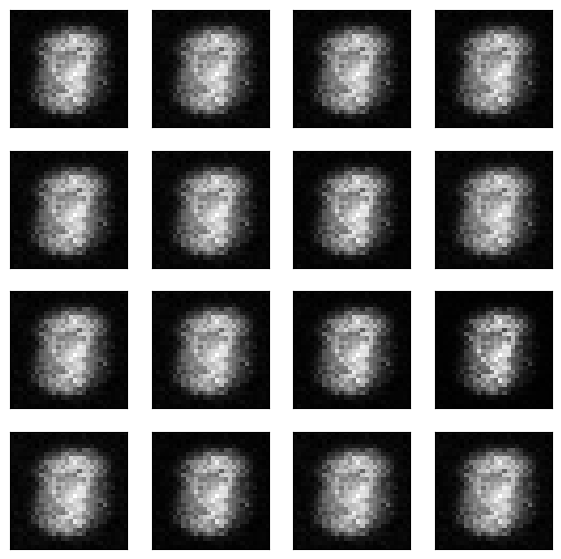

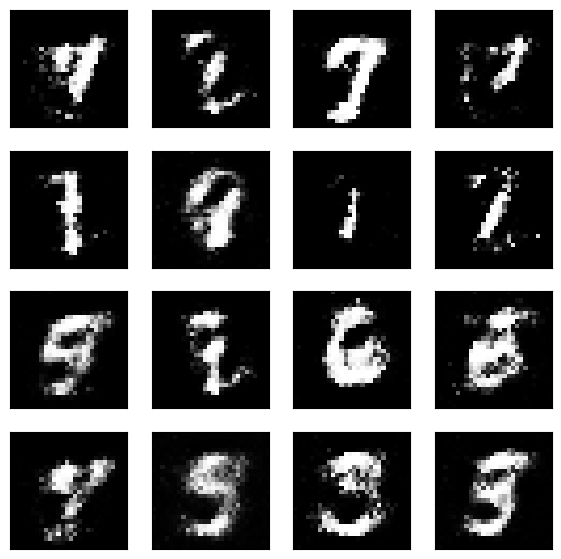

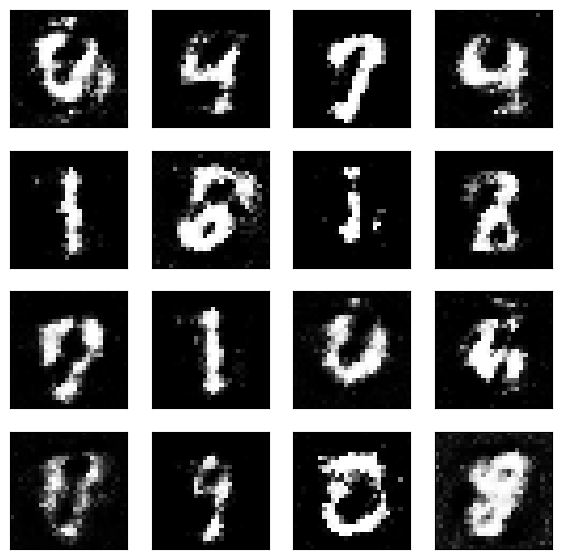

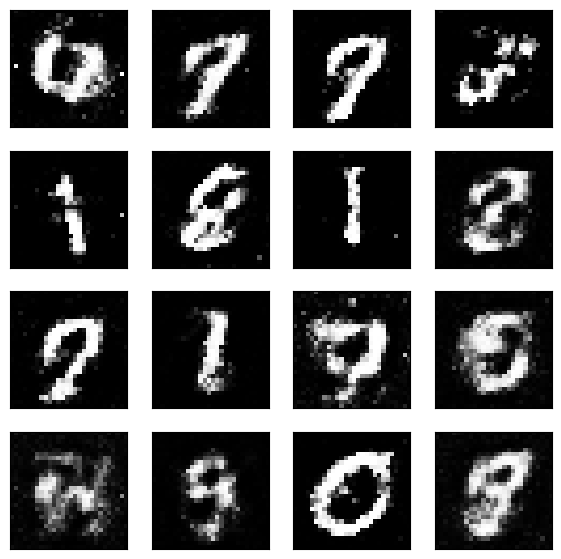

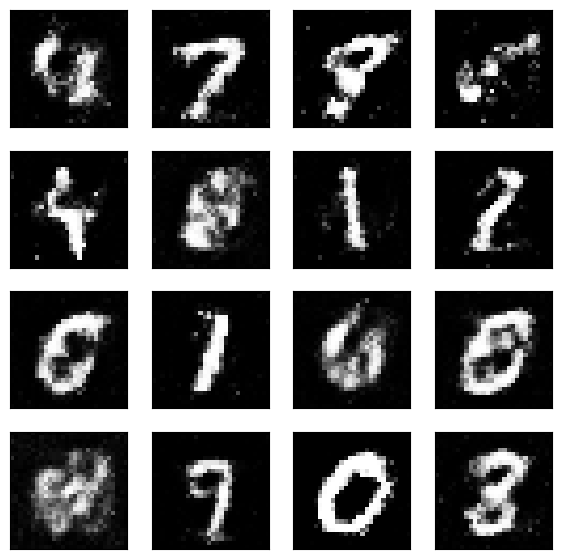

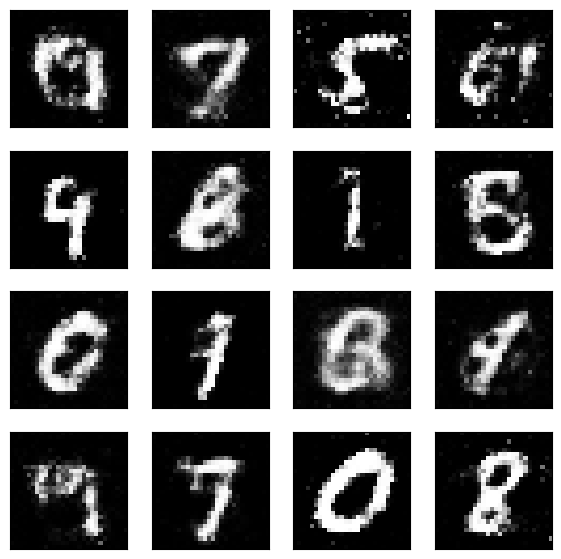

In [29]:
disc_losses1, gen_losses1 = fit(gan1, opt1,train_dl, batch_size )


Epoch  0 : Discriminator Loss =  tensor(1.2635, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8833, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  1 : Discriminator Loss =  tensor(1.2762, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8692, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  2 : Discriminator Loss =  tensor(1.2569, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.9062, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  3 : Discriminator Loss =  tensor(1.2611, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.9067, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  4 : Discriminator Loss =  tensor(1.2692, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8974, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  5 : Discriminator Loss =  tensor(1.2777, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(0.8826, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  6 :

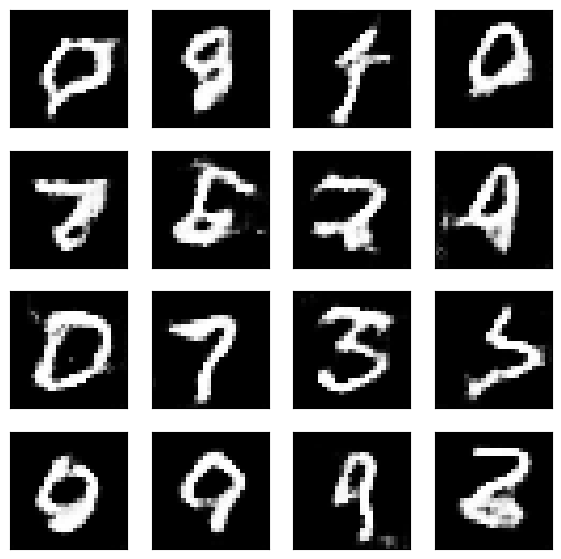

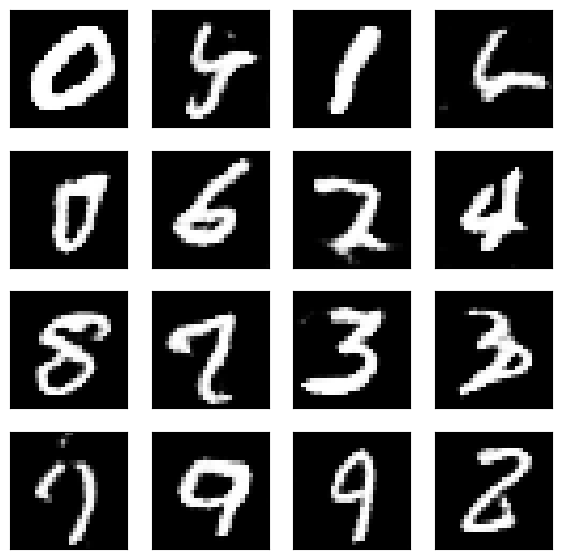

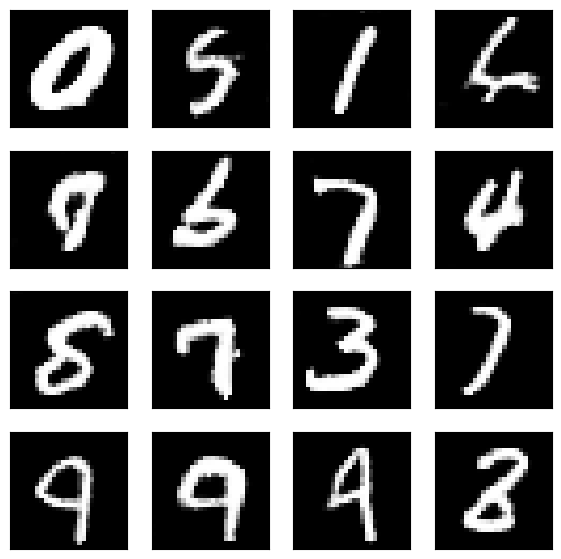

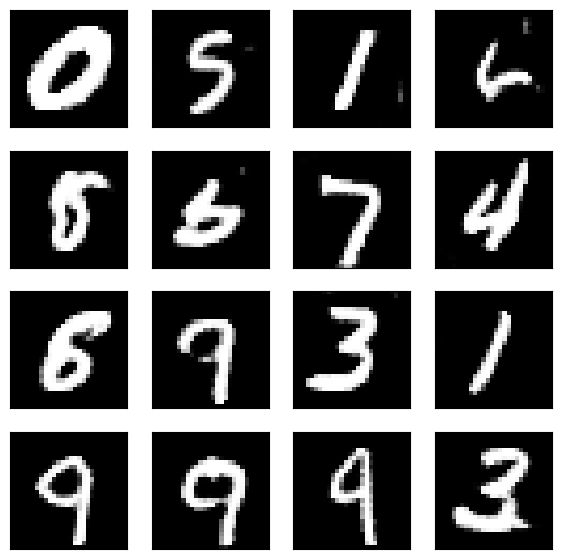

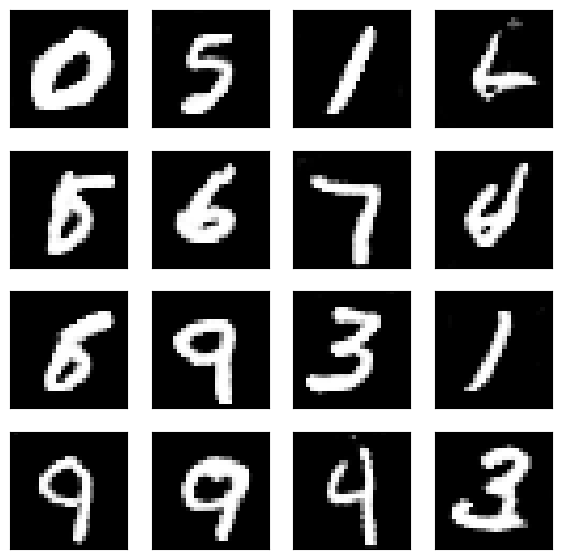

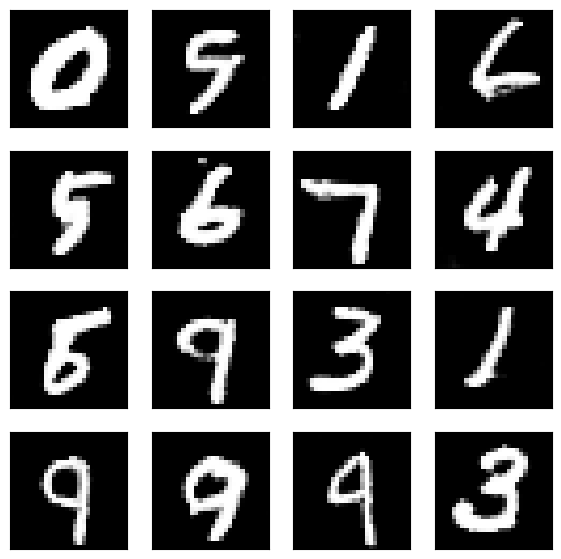

In [30]:
disc_losses2, gen_losses2 = fit(gan2, opt2,train_dl, batch_size )

# Plotting Losses
The discriminator and generator losses are plotted as a function of the number of epochs to observe the trend and allow for easier debugging.

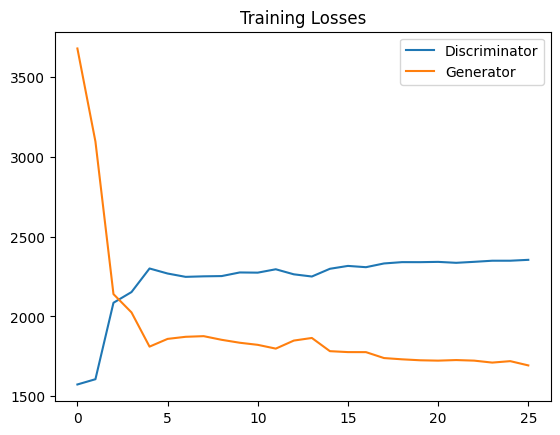

In [31]:
fig, ax = plt.subplots()
disc_losses = np.array([float(i) for i in disc_losses1])
gen_losses = np.array([float(i) for i in gen_losses1])
plt.plot(disc_losses, label='Discriminator')
plt.plot(gen_losses, label='Generator')
plt.title("Training Losses")
plt.legend()

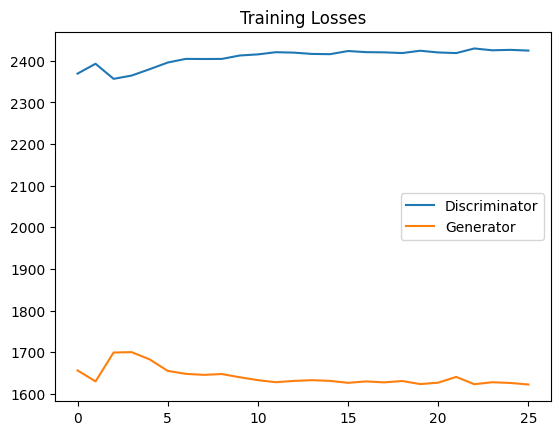

In [32]:
fig, ax = plt.subplots()
disc_losses = np.array([float(i) for i in disc_losses2])
gen_losses = np.array([float(i) for i in gen_losses2])
plt.plot(disc_losses, label='Discriminator')
plt.plot(gen_losses, label='Generator')
plt.title("Training Losses")
plt.legend()

**compare your result with GAN and DCGAN and plot both of their loss**

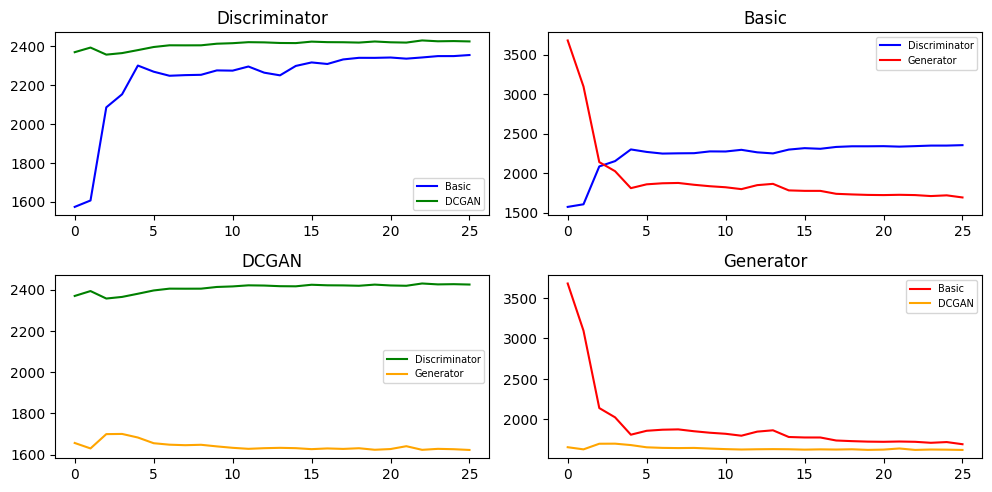

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

disc_losses1_ = np.array([float(i) for i in disc_losses1])
gen_losses1_ = np.array([float(i) for i in gen_losses1])
disc_losses2_ = np.array([float(i) for i in disc_losses2])
gen_losses2_ = np.array([float(i) for i in gen_losses2])


ax[0][0].set_title("Discriminator")
ax[0][0].plot(disc_losses1_, label="Basic", c="blue")
ax[0][0].plot(disc_losses2_, label="DCGAN", c="green")

ax[0][1].set_title("Basic")
ax[0][1].plot(disc_losses1_, label="Discriminator", c="blue")
ax[0][1].plot(gen_losses1_, label="Generator",c="red")

ax[1][0].set_title("DCGAN")
ax[1][0].plot(disc_losses2_, label="Discriminator", c="green")
ax[1][0].plot(gen_losses2_, label="Generator", c="orange")

ax[1][1].set_title("Generator")
ax[1][1].plot(gen_losses1_, label="Basic",c="red")
ax[1][1].plot(gen_losses2_, label="DCGAN", c="orange")

for a in ax.flat:
    a.legend(fontsize=7)

fig.tight_layout(pad=1)
plt.show()